In [1]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

### Set file names
outFilePath='../data/proc/'



### Other run settings
runningLocation = 'local'
if  runningLocation== 'local':
    hisOSSEFilePath='../data/raw/newRepeat/'
    hisTruthFilePath='../data/raw/truth/final/' # Truth file settings
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
    truthFilePath='/g/data/fu5/deg581/EAC_2yr_ObsVerification_HighRes/output/' # Truth file settings

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'

loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [2]:
def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName


def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def addZDimension(ds):
    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta.fillna(0) * (1 + Zo_rho/ds.h) # replace nan values in zeta with 0
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta.fillna(0) + (ds.zeta.fillna(0) + ds.h) * Zo_rho
    ds.coords['z_rho'] = z_rho.transpose()   # needing transpose seems to be an xarray bug



In [3]:
from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds


In [4]:
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

In [5]:
### Open truth file
OverlappedTruthFiles = 'yes'
if OverlappedTruthFiles == 'yes':
    truth_raw = loadOverlappedNetcdf(hisTruthFilePath,prefixTruth,filestring='080[0-7]*.nc',overlapDays=7)
elif OverlappedTruthFiles == 'no':
    import glob
    chunks = {'ocean_time':1}

    filelist = glob.glob(hisTruthFilePath+prefixTruth+'0800*.nc')
    #datelist = np.array(range(timeRange[0],timeRange[1],4))

    for files in filelist: 
        print(files)
        # filelist.append(files)
    truth = xr.open_mfdataset(filelist,chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right') 
    # truth = dropDuplicateTimes(truth)


loaded from ../data/raw/truth/final/outer_his_08001.nc to ../data/raw/truth/final/outer_his_08077.nc


In [6]:
osseAna_raw = loadOSSE(hisOSSEFilePath,prefixAnalysis,filestring='08*.nc',overlapDays=7)
osseFore_raw = loadOSSE(hisOSSEFilePath,prefixForecast,filestring='08*.nc',overlapDays=7)


loaded from ../data/raw/newRepeat/roms_fwd_outer1_08005.nc to ../data/raw/newRepeat/roms_fwd_outer1_08077.nc
loaded from ../data/raw/newRepeat/roms_fwd_outer0_08005.nc to ../data/raw/newRepeat/roms_fwd_outer0_08077.nc


In [7]:
osseAna = processROMSGrid(osseAna_raw)
osseFore = processROMSGrid(osseFore_raw)
truth = processROMSGrid(truth_raw)

grid = makeROMSGridObject(osseAna)

In [8]:
def horizontalSectionROMS(grid, inData, Var, depth):
    var_data = inData[Var]
    depth_data=inData['z_rho']
    outData = grid.transform(var_data, 'Z', depth, 
        target_data=depth_data, 
        method='linear')
    return outData

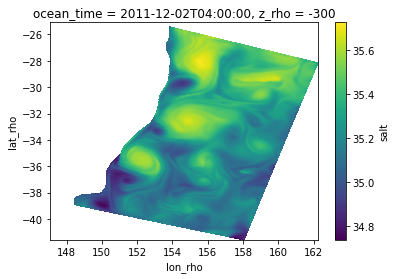

In [9]:
salt_500m = horizontalSectionROMS(grid,osseAna.isel(ocean_time=1),'salt',np.array([-300]))

salt_500m.plot(x='lon_rho',y='lat_rho')

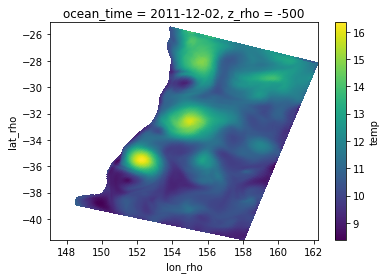

In [10]:
snapshot = osseAna.isel(ocean_time=0)
temp_snapshot = snapshot['temp']
depth_snapshot = snapshot['z_rho']

# snapshot.temp.isel(eta_rho=316).plot(x='lon_rho',y='z_rho',subplot_kws={'facecolor':'grey'})

temp_500m = grid.transform(temp_snapshot, 'Z', np.array([-500]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m.plot(x='lon_rho',y='lat_rho')

/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


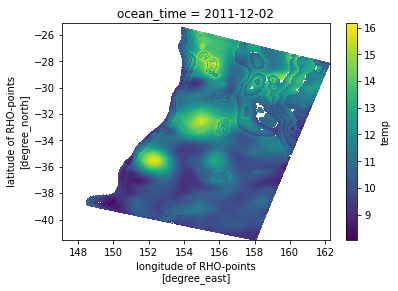

In [11]:
test= osseAna.where((osseAna['z_rho'] > -550) & (osseAna['z_rho']<-450)).mean('s_rho',skipna=True)

test.temp.isel(ocean_time=0).plot(x='lon_rho',y='lat_rho')

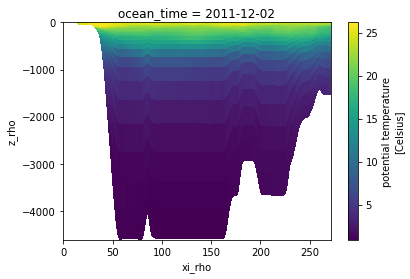

In [12]:
section=osseAna.temp.isel(eta_rho=316,ocean_time=0).plot(y='z_rho')

# section2=osseAna.temp.isel(ocean_time=0).where(osseAna.z_rho=slice(-1200,-1000)).mean(dim='s_rho',skipna=True)

In [13]:
depthVal = -500
osseAna_temp500m = horizontalSectionROMS(grid,osseAna,'temp',np.array([depthVal]))
osseFore_temp500m = horizontalSectionROMS(grid,osseFore,'temp',np.array([depthVal]))
truth_temp500m = horizontalSectionROMS(grid,truth,'temp',np.array([depthVal]))

#xiRangeMetric = [85, 150] # upstream
#etaRangeMetric = [115, 200] #upstream
etaRangeMetric = [0, 315] # whole domain
xiRangeMetric = [0, 270] # whole domain

err,temp500_rmse_Ana_Truth = calc_rmseSpatial(osseAna_temp500m,truth_temp500m,etaRangeMetric,xiRangeMetric)
err,temp500_rmse_Fore_Truth = calc_rmseSpatial(osseFore_temp500m,truth_temp500m,etaRangeMetric,xiRangeMetric)
err,temp500_rmse_Ana_Fore = calc_rmseSpatial(osseAna_temp500m,osseFore_temp500m,etaRangeMetric,xiRangeMetric)

names = ('temp500_rmse_Ana_Truth','temp500_rmse_Fore_Truth','temp500_rmse_Ana_Fore')
xlabels = ('degC','degC','degC')
rmse_metrics = xr.Dataset()

for name in names:
    rmse_metrics[name] = eval(name)

plt_params = {'linewidth':2}


temp500_rmse_Ana_Fore

# fig, axes = plt.subplots(3, figsize=(6, 8), sharex=True)
# for ax, run in zip(axes, names):
#     simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
#     ax.set_title(run, fontsize='small',loc='center')
#     ax.tick_params('x',labelrotation=45)



# fig, ax = plt.subplots(1, figsize=(8,3), sharex=True)
# for run in names:
#     plt_params['label'] = run
#     simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
# ax.set_title(run, fontsize='small',loc='center')
# ax.legend()
# ax.tick_params('x',labelrotation=45)

<xarray.DataArray 'temp' (ocean_time: 456, z_rho: 1)>
dask.array<mean_agg-aggregate, shape=(456, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 ... 2012-02-15T20:00:00
  * z_rho       (z_rho) int64 -500

In [14]:
rmse_metrics.temp500_rmse_Ana_Truth.values

In [ ]:
#xiRangeMetric = [85, 150] # upstream
#etaRangeMetric = [115, 200] #upstream
etaRangeMetric = [0, 315] # whole domain
xiRangeMetric = [0, 270] # whole domain

err,ssh_rmse_Ana_Truth = calc_rmseSpatial(osseAna.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)
err,ssh_rmse_Fore_Truth = calc_rmseSpatial(osseFore.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)
err,ssh_rmse_Ana_Fore = calc_rmseSpatial(osseAna.zeta,osseFore.zeta,etaRangeMetric,xiRangeMetric)



Error: Kernel is dead

/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


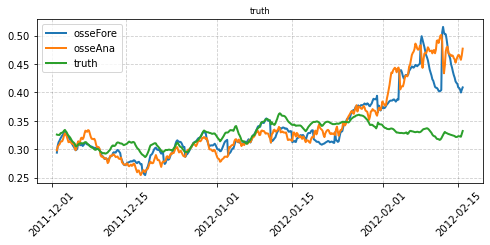

In [ ]:
names = ('osseFore','osseAna','truth')
subname ='.zeta'
xlabels = ('m','m','m')
ssh_mean_timeseries = xr.Dataset()

for name in names:
    ssh_mean_timeseries[name] = eval('indexMeanMetric('+name+subname+', etaRange=etaRangeMetric, xiRange=xiRangeMetric)')

plt_params = {'linewidth':2}

fig, ax = plt.subplots(1, figsize=(8,3), sharex=True)
for run in names:
    plt_params['label'] = run
    simple_TimeSeries(ssh_mean_timeseries['ocean_time'],ssh_mean_timeseries[run],ax=ax, plt_kwargs=plt_params)
ax.set_title(run, fontsize='small',loc='center')
ax.legend()
ax.tick_params('x',labelrotation=45)

/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarni

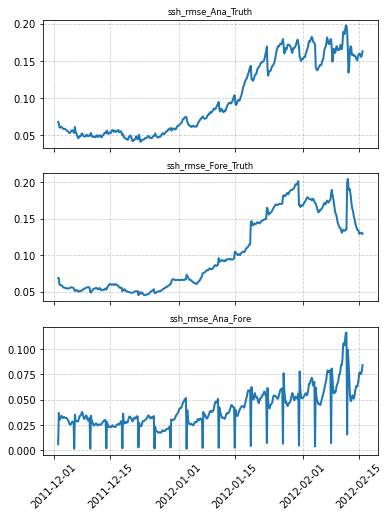

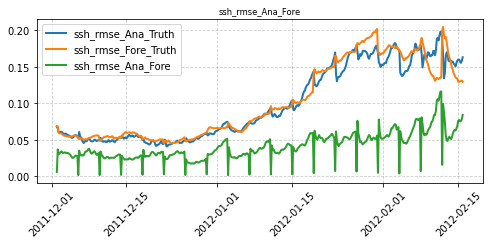

In [ ]:
names = ('ssh_rmse_Ana_Truth','ssh_rmse_Fore_Truth','ssh_rmse_Ana_Fore')
xlabels = ('m','m','m')
rmse_metrics = xr.Dataset()

for name in names:
    rmse_metrics[name] = eval(name)

plt_params = {'linewidth':2}


fig, axes = plt.subplots(3, figsize=(6, 8), sharex=True)
for ax, run in zip(axes, names):
    simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
    ax.set_title(run, fontsize='small',loc='center')
    ax.tick_params('x',labelrotation=45)



fig, ax = plt.subplots(1, figsize=(8,3), sharex=True)
for run in names:
    plt_params['label'] = run
    simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
ax.set_title(run, fontsize='small',loc='center')
ax.legend()
ax.tick_params('x',labelrotation=45)

/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


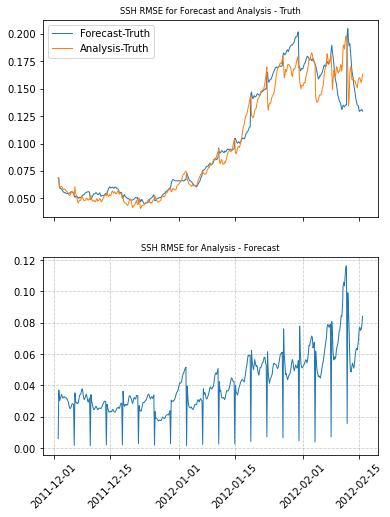

In [ ]:

plt_params = {'linewidth':1}

fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax=axes[0]
plt_params = {'linewidth':1,'label':'Forecast-Truth'}
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Fore_Truth'],ax=ax, plt_kwargs=plt_params)
plt_params = {'linewidth':1,'label':'Analysis-Truth'}
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Ana_Truth'],ax=ax, plt_kwargs=plt_params)
ax.set_title('SSH RMSE for Forecast and Analysis - Truth', fontsize='small',loc='center')
ax.legend()
ax=axes[1]
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Ana_Fore'],ax=ax, plt_kwargs=plt_params)
ax.set_title('SSH RMSE for Analysis - Forecast', fontsize='small',loc='center')
ax.tick_params('x',labelrotation=45)


In [ ]:
def plot_spatialMap(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)   


In [ ]:
# xiRange = [114, 184]
# etaRange = [84, 149]



boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)


fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMap(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

TypeError: 'Grid' object is not subscriptable